In [21]:
# Import necessary libraries
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
# Set a seed for reproducibility
torch.manual_seed(42)

# Define a transform to normalize the data to [0, 1]
transform = transforms.Compose([
    transforms.ToTensor()  # Automatically scales pixel values to [0, 1]
])

# Load the FashionMNIST dataset
train_dataset_full = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# Split the training data into training and validation sets (80-20 split)
train_size = int(0.8 * len(train_dataset_full))
val_size = len(train_dataset_full) - train_size
train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size])

# Use DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [3]:
print(f"Total training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Total training samples: 48000
Validation samples: 12000
Test samples: 10000


In [4]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # (28x28) -> (14x14)
        x = self.pool(F.relu(self.conv2(x)))   # (14x14) -> (7x7)
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [5]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10, model_name="Model"):
    print(f"\n=== Starting Training for {model_name} ===\n")

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}", flush=True)

    return train_losses, val_losses


=== Starting Training for Baseline CNN ===

Epoch 1/10, Train Loss: 0.5375, Val Loss: 0.3625
Epoch 2/10, Train Loss: 0.3443, Val Loss: 0.2895
Epoch 3/10, Train Loss: 0.2936, Val Loss: 0.2832
Epoch 4/10, Train Loss: 0.2652, Val Loss: 0.2537
Epoch 5/10, Train Loss: 0.2402, Val Loss: 0.2477
Epoch 6/10, Train Loss: 0.2207, Val Loss: 0.2410
Epoch 7/10, Train Loss: 0.2028, Val Loss: 0.2487
Epoch 8/10, Train Loss: 0.1846, Val Loss: 0.2300
Epoch 9/10, Train Loss: 0.1742, Val Loss: 0.2280
Epoch 10/10, Train Loss: 0.1581, Val Loss: 0.2246


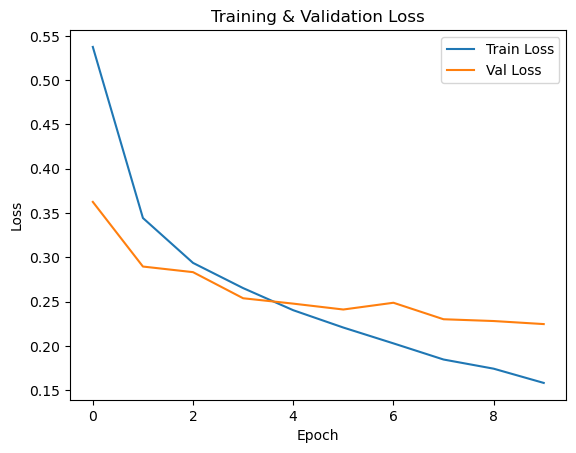

In [6]:
# Instantiate everything as usual
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FashionCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train
train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    epochs=10,
    model_name="Baseline CNN"
)

# Plot loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

Test Accuracy: 91.95%


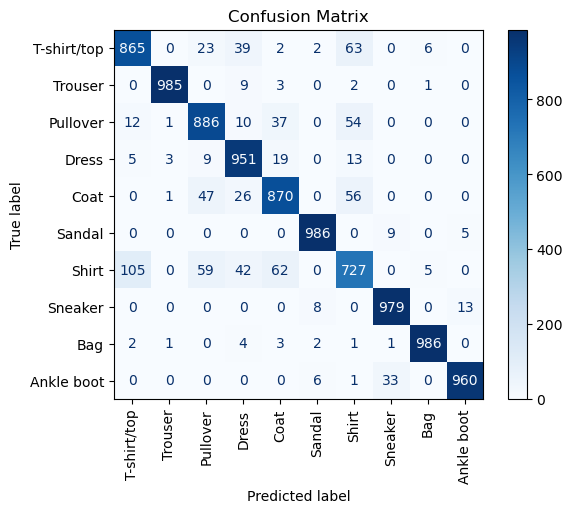

In [7]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Accuracy
test_accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

In [8]:
# Model 1 — Batch Normalization Only
class FashionCNN_BatchNorm(nn.Module):
    def __init__(self):
        super(FashionCNN_BatchNorm, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(F.relu(self.fc1(x)))
        return self.fc2(x)

In [9]:
def train_model_bn(model, train_loader, val_loader, criterion, optimizer, device, epochs=10, model_name="BatchNorm Model"):
    print(f"\n=== Starting Training for {model_name} ===\n")

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"[{model_name}] Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}", flush=True)

    return train_losses, val_losses


=== Starting Training for BatchNorm CNN ===

[BatchNorm CNN] Epoch 1/10, Train Loss: 0.4337, Val Loss: 0.3219
[BatchNorm CNN] Epoch 2/10, Train Loss: 0.2993, Val Loss: 0.3052
[BatchNorm CNN] Epoch 3/10, Train Loss: 0.2622, Val Loss: 0.2676
[BatchNorm CNN] Epoch 4/10, Train Loss: 0.2344, Val Loss: 0.2626
[BatchNorm CNN] Epoch 5/10, Train Loss: 0.2119, Val Loss: 0.2282
[BatchNorm CNN] Epoch 6/10, Train Loss: 0.1934, Val Loss: 0.2195
[BatchNorm CNN] Epoch 7/10, Train Loss: 0.1772, Val Loss: 0.2277
[BatchNorm CNN] Epoch 8/10, Train Loss: 0.1607, Val Loss: 0.2313
[BatchNorm CNN] Epoch 9/10, Train Loss: 0.1481, Val Loss: 0.2368
[BatchNorm CNN] Epoch 10/10, Train Loss: 0.1337, Val Loss: 0.2176


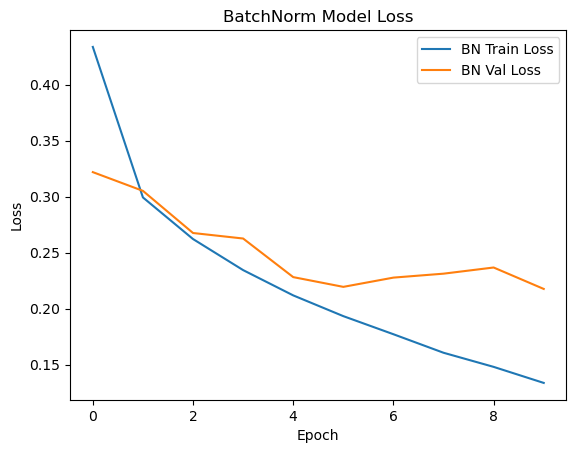

In [10]:
# Instantiate BatchNorm model
model_bn = FashionCNN_BatchNorm().to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_bn.parameters(), lr=0.001)

# Call training function
train_losses_bn, val_losses_bn = train_model_bn(
    model=model_bn,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    model_name="BatchNorm CNN"
)

# Plot
plt.plot(train_losses_bn, label='BN Train Loss')
plt.plot(val_losses_bn, label='BN Val Loss')
plt.title("BatchNorm Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

BatchNorm Model Test Accuracy: 92.00%


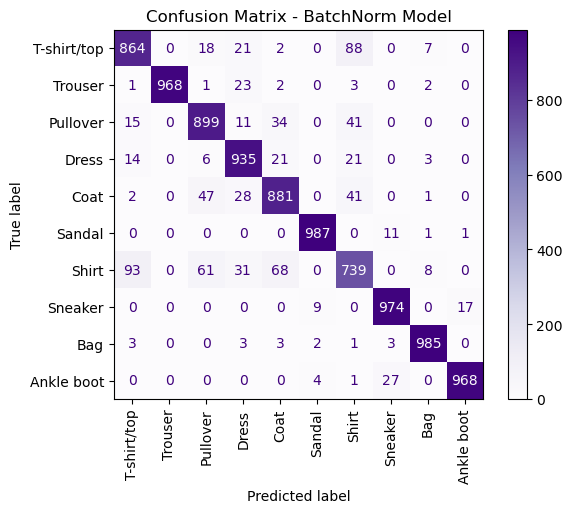

In [11]:
# Evaluate
model_bn.eval()
all_preds_bn, all_labels_bn = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model_bn(images)
        _, preds = torch.max(outputs, 1)
        all_preds_bn.extend(preds.cpu().numpy())
        all_labels_bn.extend(labels.numpy())

accuracy_bn = accuracy_score(all_labels_bn, all_preds_bn)
print(f"BatchNorm Model Test Accuracy: {accuracy_bn * 100:.2f}%")

cm_bn = confusion_matrix(all_labels_bn, all_preds_bn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_bn, display_labels=test_dataset.classes)
disp.plot(cmap='Purples', xticks_rotation='vertical')
plt.title("Confusion Matrix - BatchNorm Model")
plt.show()

In [12]:
# Data Augmentation Only — New train transform
augmented_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

# Load datasets
train_dataset_aug = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=augmented_transform
)

val_dataset_clean = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

# Manual split to prevent augmentation in val set
train_size = int(0.8 * len(train_dataset_aug))
val_size = len(train_dataset_aug) - train_size
train_aug, _ = random_split(train_dataset_aug, [train_size, val_size])
_, val_clean = random_split(val_dataset_clean, [train_size, val_size])

train_loader_aug = DataLoader(train_aug, batch_size=64, shuffle=True)
val_loader_clean = DataLoader(val_clean, batch_size=64)

# Define original baseline model again
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(F.relu(self.fc1(x)))
        return self.fc2(x)

In [13]:
def train_model_aug(model, train_loader, val_loader, criterion, optimizer, device, epochs=10, model_name="Augmented Model"):
    print(f"\n=== Starting Training for {model_name} ===\n")

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"[{model_name}] Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}", flush=True)

    return train_losses, val_losses


=== Starting Training for Augmented CNN ===

[Augmented CNN] Epoch 1/10, Train Loss: 0.5977, Val Loss: 0.3715
[Augmented CNN] Epoch 2/10, Train Loss: 0.4034, Val Loss: 0.3218
[Augmented CNN] Epoch 3/10, Train Loss: 0.3572, Val Loss: 0.2754
[Augmented CNN] Epoch 4/10, Train Loss: 0.3241, Val Loss: 0.2596
[Augmented CNN] Epoch 5/10, Train Loss: 0.3029, Val Loss: 0.2407
[Augmented CNN] Epoch 6/10, Train Loss: 0.2930, Val Loss: 0.2312
[Augmented CNN] Epoch 7/10, Train Loss: 0.2750, Val Loss: 0.2257
[Augmented CNN] Epoch 8/10, Train Loss: 0.2599, Val Loss: 0.2094
[Augmented CNN] Epoch 9/10, Train Loss: 0.2533, Val Loss: 0.2086
[Augmented CNN] Epoch 10/10, Train Loss: 0.2446, Val Loss: 0.1945


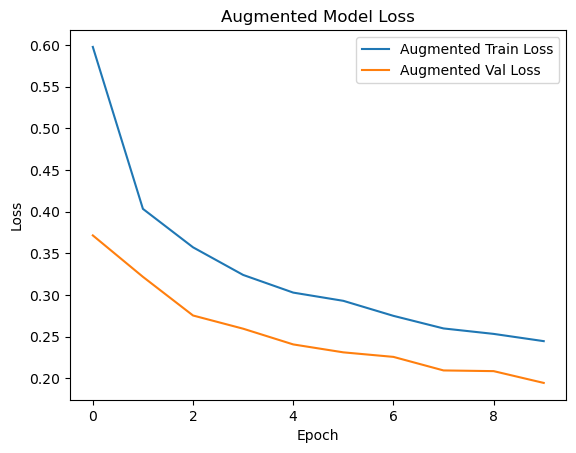

In [14]:
# Instantiate model for augmented training
model_aug = FashionCNN().to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_aug.parameters(), lr=0.001)

# Train using augmented train/val loaders
train_losses_aug, val_losses_aug = train_model_aug(
    model=model_aug,
    train_loader=train_loader_aug,      # Augmented training loader
    val_loader=val_loader_clean,        # Clean validation loader
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    model_name="Augmented CNN"
)

# Plot
plt.plot(train_losses_aug, label='Augmented Train Loss')
plt.plot(val_losses_aug, label='Augmented Val Loss')
plt.title("Augmented Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Augmented Model Test Accuracy: 91.45%


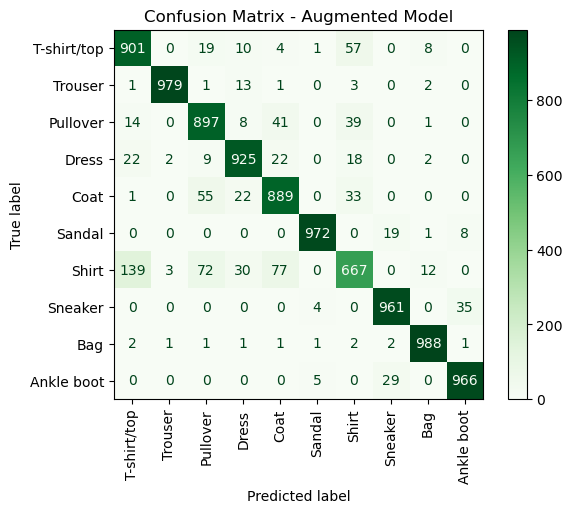

In [17]:
# Evaluate
model_aug.eval()
all_preds_aug, all_labels_aug = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model_aug(images)
        _, preds = torch.max(outputs, 1)
        all_preds_aug.extend(preds.cpu().numpy())
        all_labels_aug.extend(labels.numpy())

accuracy_aug = accuracy_score(all_labels_aug, all_preds_aug)
print(f"Augmented Model Test Accuracy: {accuracy_aug * 100:.2f}%")

cm_aug = confusion_matrix(all_labels_aug, all_preds_aug)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_aug, display_labels=test_dataset.classes)
disp.plot(cmap='Greens', xticks_rotation='vertical')
plt.title("Confusion Matrix - Augmented Model")
plt.show()

In [16]:
# Test accuracies (replace these with your actual values)
baseline_acc = test_accuracy
batchnorm_acc = accuracy_bn
augmented_acc = accuracy_aug

# Print a simple comparison table
print("\n=== Test Accuracy Comparison ===")
print(f"{'Model':<20} {'Test Accuracy':>15}")
print("-" * 35)
print(f"{'Baseline':<20} {baseline_acc:>13.2f}%")
print(f"{'BatchNorm':<20} {batchnorm_acc:>13.2f}%")
print(f"{'Augmented':<20} {augmented_acc:>13.2f}%")


=== Test Accuracy Comparison ===
Model                  Test Accuracy
-----------------------------------
Baseline                      0.92%
BatchNorm                     0.92%
Augmented                     0.91%


In [20]:
def print_metrics(preds, labels, model_name="Model"):
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro', zero_division=0)
    recall = recall_score(labels, preds, average='macro', zero_division=0)
    f1 = f1_score(labels, preds, average='macro', zero_division=0)

    print(f"\n=== {model_name} Evaluation Metrics ===")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-Score : {f1:.4f}")

# Print metrics for each model
print_metrics(all_preds, all_labels, model_name="Baseline CNN")
print_metrics(all_preds_bn, all_labels_bn, model_name="BatchNorm CNN")
print_metrics(all_preds_aug, all_labels_aug, model_name="Augmented CNN")


=== Baseline CNN Evaluation Metrics ===
Accuracy : 0.9195
Precision: 0.9189
Recall   : 0.9195
F1-Score : 0.9189

=== BatchNorm CNN Evaluation Metrics ===
Accuracy : 0.9200
Precision: 0.9197
Recall   : 0.9200
F1-Score : 0.9197

=== Augmented CNN Evaluation Metrics ===
Accuracy : 0.9145
Precision: 0.9139
Recall   : 0.9145
F1-Score : 0.9133
